In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
board_games = pd.read_csv("board_games.csv")

In [4]:
board_games.head()

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


In [5]:
board_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81312 entries, 0 to 81311
Data columns (total 20 columns):
id                      81312 non-null int64
type                    81312 non-null object
name                    81271 non-null object
yearpublished           81309 non-null float64
minplayers              81309 non-null float64
maxplayers              81309 non-null float64
playingtime             81309 non-null float64
minplaytime             81309 non-null float64
maxplaytime             81309 non-null float64
minage                  81309 non-null float64
users_rated             81312 non-null int64
average_rating          81312 non-null float64
bayes_average_rating    81312 non-null float64
total_owners            81312 non-null int64
total_traders           81312 non-null int64
total_wanters           81312 non-null int64
total_wishers           81312 non-null int64
total_comments          81312 non-null int64
total_weights           81312 non-null int64
average_weight  

In [6]:
board_games.dropna(axis=0,inplace=True)

In [12]:
board_games = board_games[board_games.users_rated > 0]

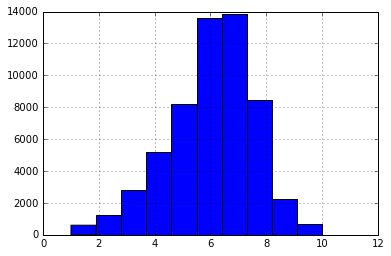

In [17]:
board_games.average_rating.hist()

In [18]:
np.std(board_games.average_rating)

1.5788160595839511

In [19]:
np.mean(board_games.average_rating)

6.0161128493338492

## Error metric
In this data set, using mean squared error as an error metric makes sense. This is because the data is continuous, and follows a somewhat normal distribution(slightly sckewed to the left). We'll be able to compare our error to the standard deviation to see how good the model is at predictions.

In [20]:
from sklearn.cluster import KMeans

In [21]:
k_clusters = KMeans(5,random_state=1)

In [30]:
#remove non-numerical colums to fit K-clustering model
cols = [i for i in board_games.columns.tolist() \
        if i not in ['name','type','id']]
numeric_cols = board_games[cols]
k_clusters.fit(numeric_cols)
labels = k_clusters.labels_

In [37]:
game_mean = numeric_cols.apply(np.mean,axis=1)
game_std = numeric_cols.apply(np.std,axis=1)

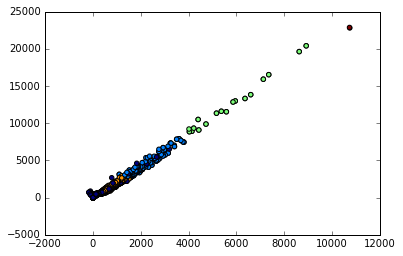

In [39]:
plt.scatter(game_mean,game_std,c=labels)

## Game clusters
It looks like most of the games are similar, but as the game attributes tend to increase in value (such as number of users who rated), there are fewer high quality games. So most games don't get played much, but a few get a lot of players.

In [40]:
correlations = numeric_cols.corr()

In [41]:
correlations.average_rating

yearpublished           0.108461
minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
Name: average_rating, dtype: float64

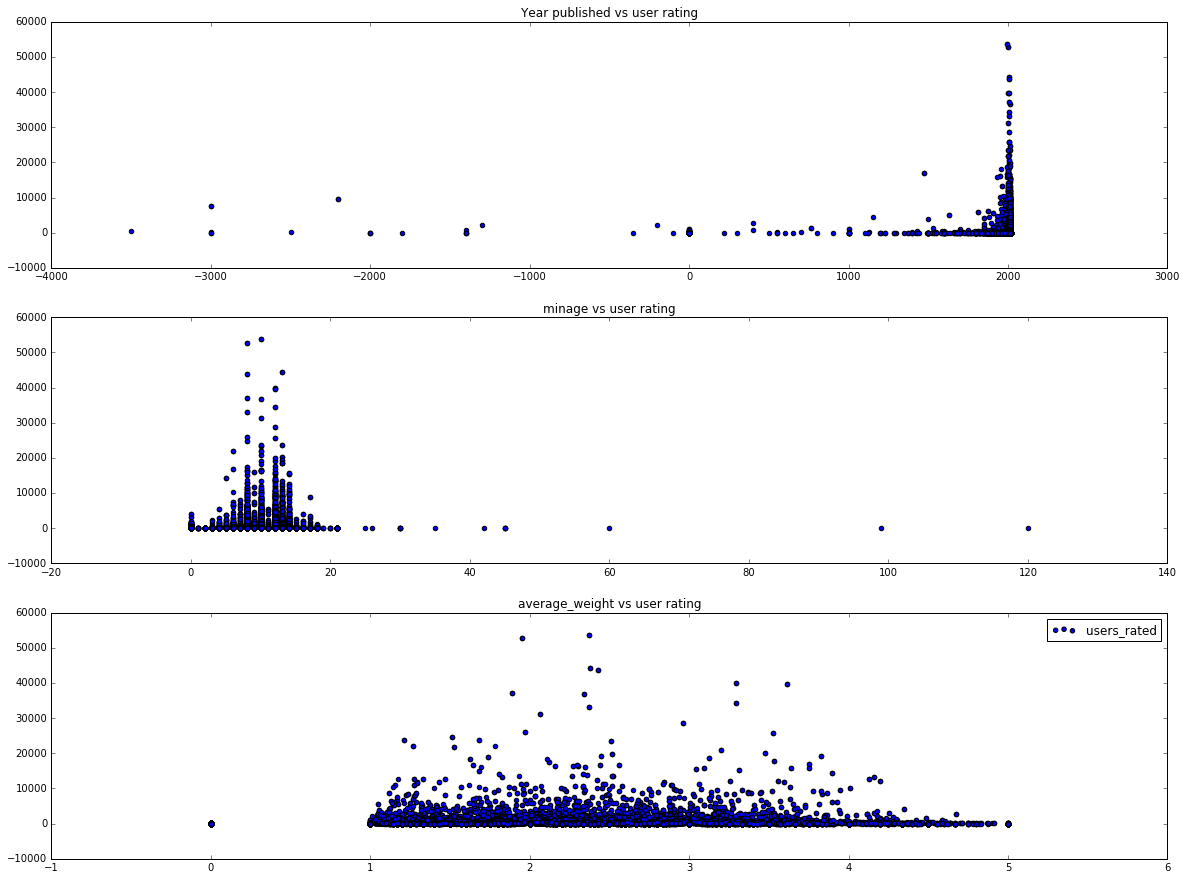

In [52]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,15))
ax1.scatter(numeric_cols.yearpublished,numeric_cols.users_rated)
ax1.set_title("Year published vs user rating")
ax2.scatter(numeric_cols.minage,numeric_cols.users_rated)
ax2.set_title("minage vs user rating")
ax3.scatter(numeric_cols.average_weight,numeric_cols.users_rated)
ax3.set_title("average_weight vs user rating")
plt.legend()

## Correlations
The yearpublished column is surprisingly highly correlated with average_rating, showing that more recent games tend to be rated more highly. Games for older players (minage is high) tend to be more highly rated. The more "weighty" a game is (average_weight is high), the more highly it tends to be rated.

bayes_average_rating was ommited from this analysis as it it calculated using the average_rating and might cause the model the overfit

In [53]:
from sklearn.linear_model import LinearRegression

In [59]:
reg_model = LinearRegression()
cols = ['yearpublished','minage','average_weight']
reg_model.fit(board_games[cols], board_games["average_rating"])
predictions = reg_model.predict(board_games[cols])


In [60]:
predictions

array([ 7.15110384,  7.28165147,  7.23392971, ...,  6.18468732,
        5.54008082,  6.15050266])

In [61]:
np.mean((predictions - board_games["average_rating"]) ** 2)

2.1405805187011264

## Game clusters
The error rate is close to the standard deviation of all board game ratings. This indicates that our model may not have high predictive power. We'll need to dig more into which games were scored well, and which ones weren't.